# Random assignment, binary CATE example

This is a fully worked-out notebook showing how you would apply `CausalTune` to a dataset.

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import warnings
warnings.filterwarnings('ignore') # suppress sklearn deprecation warnings for now..

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# the below checks for whether we run dowhy, causaltune, and FLAML from source
root_path = root_path = os.path.realpath('../..')
try:
    import causaltune
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "causaltune"))

try:
    import dowhy
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "dowhy"))

try:
    import flaml
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "FLAML"))


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# this makes the notebook expand to full width of the browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%%javascript

// turn off scrollable windows for large output
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
from causaltune import CausalTune
from causaltune.datasets import synth_ihdp
from causaltune.data_utils import CausalityDataset

### Model fitting & scoring
Here we fit a (selection of) model(s) to the data and score them with the energy distance metric on held-out data.

We import an example dataset and pre-process it. The pre-processing fills in the NaNs and one-hot-encodes all categorical and int variables.

If you don't want an int variable to be one-hot-encoded, please cast it to float before preprocessing.

In [5]:
# load toy dataset
df = synth_ihdp(return_df=True)
display(df.head())

,treatment,y_factual,x1,x2,x3,x4,x5,x6,x7,x8,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,1,5.599916,-0.528603,-0.343455,1.128554,0.161703,-0.316603,1.295216,1,0,...,1,1,1,1,0,0,0,0,0,0
1,0,6.875856,-1.736945,-1.802002,0.383828,2.244320,-0.629189,1.295216,0,0,...,1,1,1,1,0,0,0,0,0,0
2,0,2.996273,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,-0.526556,0,0,...,1,0,1,1,0,0,0,0,0,0
3,0,1.366206,0.390083,0.596582,-1.850350,-0.879606,-0.004017,-0.857787,0,0,...,1,0,1,1,0,0,0,0,0,0
4,0,1.963538,-1.045229,-0.602710,0.011465,0.161703,0.683672,-0.360940,1,0,...,1,1,1,1,0,0,0,0,0,0


In [6]:
# split-off a hold-out set
hold_out = df.sample(frac=0.2)
train = df.drop(hold_out.index)

In [7]:
# apply standard pre-processing to train set
cd = CausalityDataset(data=train, treatment='treatment', outcomes=['y_factual'])
cd.preprocess_dataset()

Inspecting the dataset below, we can see that the causal inference problem is defined by a binary `treatment`, a continuous outcome `y_factual`, and a range of covariates `x_{i}`. The `random` column is added to bypass a DoWhy bug.

In [8]:
# inspect the preprocessed dataset
display(cd.data.head())

,treatment,y_factual,random,x1,x2,x3,x4,x5,x6,x7,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,1,5.599916,1.0,-0.528603,-0.343455,1.128554,0.161703,-0.316603,1.295216,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,6.875856,0.0,-1.736945,-1.802002,0.383828,2.244319,-0.629189,1.295216,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2.996273,1.0,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,-0.526556,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1.366206,1.0,0.390083,0.596582,-1.850350,-0.879606,-0.004017,-0.857787,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1.963538,0.0,-1.045228,-0.602710,0.011465,0.161703,0.683672,-0.360940,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Fitting the model is as simple as calling `CausalTune.fit()`, with the only required parameter apart from the data being the amount of time you want to give the optimizer, either for the whole run (`time_budget`) or per FLAML component model (`components_time_budget`), or both.

If you want to use specific estimators, comment in the `estimator_list` below to include any estimators whose full name contains any of the elements of `estimator_list`.

The other allowed values are `all` and `auto`, the default is `auto`.


In [9]:
estimator_list = [
             "SparseLinearDML",
             "ForestDRLearner",
            "TransformedOutcome",
            "CausalForestDML",
            ".LinearDML",
            "DomainAdaptationLearner",
            "SLearner",
            "XLearner",
            "TLearner",
             #"Ortho",       
    ]             

# set evaluation metric
metric = "frobenius_norm"

# it's best to specify either time_budget or components_time_budget, 
# and let the other one be inferred; time in seconds
time_budget = None
components_time_budget = 10

# specify training set size
train_size = 0.7

best_estimators = []
best_configs = []
best_scores = []

for estimator in estimator_list:
    print("ESTIMATOR: ", estimator)
    ct = CausalTune(
    estimator_list=[estimator],
    metric=metric,
    verbose=0,
    components_verbose=0,
    time_budget=time_budget,
    components_time_budget=components_time_budget,
    train_size=train_size
    )
    # run causaltune
    ct.fit(data=cd, outcome=cd.outcomes[0])

    best_estimators.append(ct.best_estimator)
    best_configs.append(ct.best_config)
    best_scores.append(ct.best_score)

    print('---------------------')

    # return best estimator
    print(f"Best estimator: {ct.best_estimator}")
    # config of best estimator:
    print(f"Best config: {ct.best_config}")
    # best score:
    print(f"Best score: {ct.best_score}")

ESTIMATOR:  SparseLinearDML
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.econml.dml.SparseLinearDML', 'fit_cate_intercept': True, 'n_alphas': 100, 'n_alphas_cov': 10, 'tol': 0.0001, 'max_iter': 10000, 'mc_agg': 'mean'}}]
erupt:  6.393658493049343
norm_erupt:  2.7409015903034275
prob_erupt:  1.3193877462077155
COMPUTING FROBENIUS
erupt:  6.411070231873237
norm_erupt:  2.4116329260111513
prob_erupt:  1.4773191485410653
COMPUTING FROBENIUS
erupt:  6.41312877389498
norm_erupt:  2.663003477770225
prob_erupt:  1.3820664211810072
COMPUTING FROBENIUS
erupt:  6.494774185419753
norm_erupt:  2.3693207512571037
prob_erupt:  1.491570871797483
COMPUTING FROBENIUS
---------------------
Best estimator: backdoor.econml.dml.SparseLinearDML
Best config: {'estimator': {'estimator_name': 'backdoor.econml.dml.SparseLinearDML', 'fit_cate_intercept': 1, 'n_alphas': 93, 'n_alphas_cov

In [48]:
print(best_estimators)
print("-------------------------------------------------")
print(best_configs)
print("-------------------------------------------------")
print(best_scores)

['backdoor.econml.dml.SparseLinearDML', 'backdoor.econml.dr.ForestDRLearner', 'backdoor.causaltune.models.TransformedOutcome', 'backdoor.econml.dml.CausalForestDML', 'backdoor.econml.dml.LinearDML', 'backdoor.econml.metalearners.DomainAdaptationLearner', 'backdoor.econml.metalearners.SLearner', 'backdoor.econml.metalearners.XLearner', 'backdoor.econml.metalearners.TLearner']
-------------------------------------------------
[{'estimator': {'estimator_name': 'backdoor.econml.dml.SparseLinearDML', 'fit_cate_intercept': 1, 'n_alphas': 100, 'n_alphas_cov': 10, 'tol': 9.999999999999999e-05, 'max_iter': 10000, 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': 1, 'subforest_size': 4}}, {'estimator': {'estimator_name

In [39]:
# training configs

# choose estimators of interest
estimator_list = [
             #"Dummy",
             #"SparseLinearDML",
             #"ForestDRLearner",
            "TransformedOutcome",
            #"CausalForestDML",
            # ".LinearDML",
            # "DomainAdaptationLearner",
            #"SLearner",
            #"XLearner",
            # "TLearner",
             #"Ortho"
    ]

# set evaluation metric
metric = "frobenius_norm"

# it's best to specify either time_budget or components_time_budget, 
# and let the other one be inferred; time in seconds
time_budget = None
components_time_budget = 30

# specify training set size
train_size = 0.7

In [38]:
# create CausalTune() instance
ct = CausalTune(
    estimator_list=estimator_list,
    metric=metric,
    verbose=0,
    components_verbose=0,
    time_budget=time_budget,
    components_time_budget=components_time_budget,
    train_size=train_size
)
# run causaltune
ct.fit(data=cd, outcome=cd.outcomes[0])
# best estimator
print(f"Best estimator: {ct.best_estimator}")
# best score:
print(f"Best score: {ct.best_score}")

Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Propensity Model Fitted Successfully
Initial configs: [{'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}]
score of <dowhy.causal_estimators.econml.Econml object at 0x3041f8f10> is: -0.0034758795028439014
score of <dowhy.causal_estimators.econml.Econml object at 0x3041f8f10> is: 0.0
score of <dowhy.causal_estimators.econml.Econml object at 0x17f868bb0> is: 0.0
score of <dowhy.causal_estimators.econml.Econml object at 0x17f868bb0> is: 0.0
---------------------
Best estimator: backdoor.econml.dr.ForestDRLearner
Best config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimato

In [ ]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

metric = "frobenius_norm"  
print(f"{out_dir}{filename_out}_{metric}_run_1.pkl")
# Create a single plot instead of subplots
fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=300)

# Load results for the single metric
with open(f"{out_dir}{filename_out}_{metric}_run_1.pkl", "rb") as f:
    results = pickle.load(f)


#print(results["scores_per_estimator"])

#print(results["best_estimator"])
# Extract CATE ground truth and estimates
CATE_gt = results["scores_per_estimator"][results["best_estimator"]][0]["test"]["CATE_groundtruth"]
CATE_est = results["scores_per_estimator"][results["best_estimator"]][0]["test"]["CATE_estimate"]
#print(CATE_est)

sd_vals = []
for el in CATE_est:
    sd_vals.append(el[0])
print("SD CATE_ests best model: ", np.std(sd_vals))

# Plot the true against estimated CATE
ax.scatter(CATE_gt, CATE_est, s=20, alpha=0.1)

# Plot the identity line
ax.plot([min(CATE_gt), max(CATE_gt)], [min(CATE_gt), max(CATE_gt)], "k-", linewidth=0.5)

# Set labels and title
ax.set_xlabel("true CATE")
ax.set_ylabel("estimated CATE")
ax.set_title(f"{results['optimised_metric']}")

# Set ticks
# ax.set_xticks(np.arange(-0.2, 0.21, 0.2))
# ax.set_yticks(np.arange(-0.2, 0.21, 0.2))
#ax.set_xlim([-0.2,0.2])
#ax.set_ylim([-0.2,0.2])

# Remove top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(f"paper_{filename_out}_mse.pdf", format="pdf")

In [31]:
ct.results.trials

In [34]:


# compute relevant scores (skip newdummy)
datasets = {"train": ct.train_df, "validation": ct.hold_out, "test": hold_out}
# get scores on train, val, test for each trial, 
# sort trials by validation set performance
# assign trials to estimators
estimator_scores = {est: [] for est in ct.scores.keys() if "NewDummy" not in est}

for trial in ct.results.trials:
    print("TRIAL: ", trial)
    # estimator name:
    estimator_name = trial.last_result["estimator_name"]
    if trial.last_result["estimator"]:
        estimator = trial.last_result["estimator"]
        scores = {}
        for ds_name, df in datasets.items():
            scores[ds_name] = {}
            # make scores
            est_scores = ct.scorer.make_scores(
                estimator,
                df,
                metrics_to_report=ct.metrics_to_report,
            )

            # add cate:
            scores[ds_name]["CATE_estimate"] = estimator.estimator.effect(df)
            # add ground truth for convenience
            scores[ds_name]["CATE_groundtruth"] = df["true_effect"]
            scores[ds_name][metric] = est_scores[metric]
        estimator_scores[estimator_name].append(scores)

# sort trials by validation performance
for k in estimator_scores.keys():
    estimator_scores[k] = sorted(
        estimator_scores[k],
        key=lambda x: x["validation"][metric],
        reverse=False if metric in ["energy_distance", "psw_energy_distance", "frobenius_norm", "codec"] else True,
    )
results = {
    "best_estimator": ct.best_estimator,
    "best_config": ct.best_config,
    "best_score": ct.best_score,
    "optimised_metric": metric,
    "scores_per_estimator": estimator_scores,
}

AttributeError: 'CausalTune' object has no attribute 'hold_out'

### ERUPT
WARNING:dowhy.causal_model:Causal Graph not provided. DoWhy will construct a graph based on data inputs.
INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ\#about-low_cost_partial_config-in-tune
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
backdoor
backdoor
Initial configs: [{'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': True, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'fit_intercept': True, 'subforest_size': 4}}]

Best estimator: backdoor.econml.dml.CausalForestDML
Best config: {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': 1, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': 1, 'fit_intercept': 1, 'subforest_size': 4}}
Best score: 6.281017541826792

### Probabilistic ERUPT

WARNING:dowhy.causal_model:Causal Graph not provided. DoWhy will construct a graph based on data inputs.
INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ\#about-low_cost_partial_config-in-tune
Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
backdoor
backdoor
Initial configs: [{'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': True, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'fit_intercept': True, 'subforest_size': 4}}]


Best estimator: backdoor.econml.dml.CausalForestDML
Best config: {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': 1, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': 1, 'fit_intercept': 1, 'subforest_size': 4}}
Best score: 4.273132956136449

After running a fit, you also have the option resume it without losing past results, for example if you want to search over extra estimators. To do so, simply pass `resume=True` to the `fit` method as shown below: 

`ct.fit(data=cd,outcome=cd.outcomes[0],resume=True)`

We will now score all estimators on the hold-out test set and save the results per estimator in `ct.scores['test']`.

In [28]:
cd_hold_out = CausalityDataset(data=hold_out, treatment='treatment', outcomes=['y_factual'])
cd_hold_out.preprocess_dataset()

ct.score_dataset(df=cd_hold_out.data, dataset_name='test')

Below we demonstrate some basic plotting functionality that comes with `CausalTune`. 

In [29]:
from causaltune.visualizer import Visualizer

viz = Visualizer(
    test_df=cd_hold_out.data,
    treatment_col_name=cd.treatment,
    outcome_col_name=cd.outcomes[0]
)

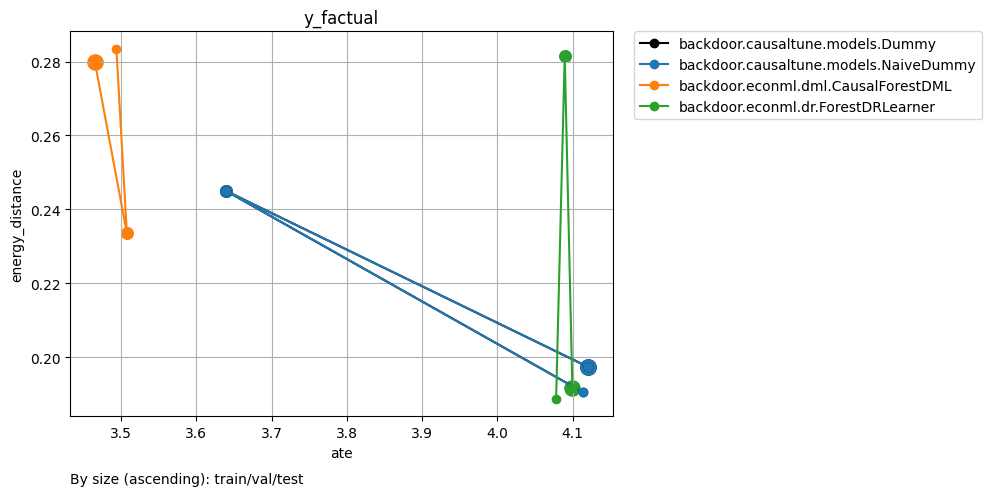

In [30]:
%matplotlib inline

# plotting metrics by estimator

figtitle = f'{viz.outcome_col_name}'
figsize = (7,5)
metrics = ('energy_distance', 'ate')

viz.plot_metrics_by_estimator(
    scores_dict=ct.scores,
    metrics=metrics,
    figtitle=figtitle,
    figsize=figsize
)

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

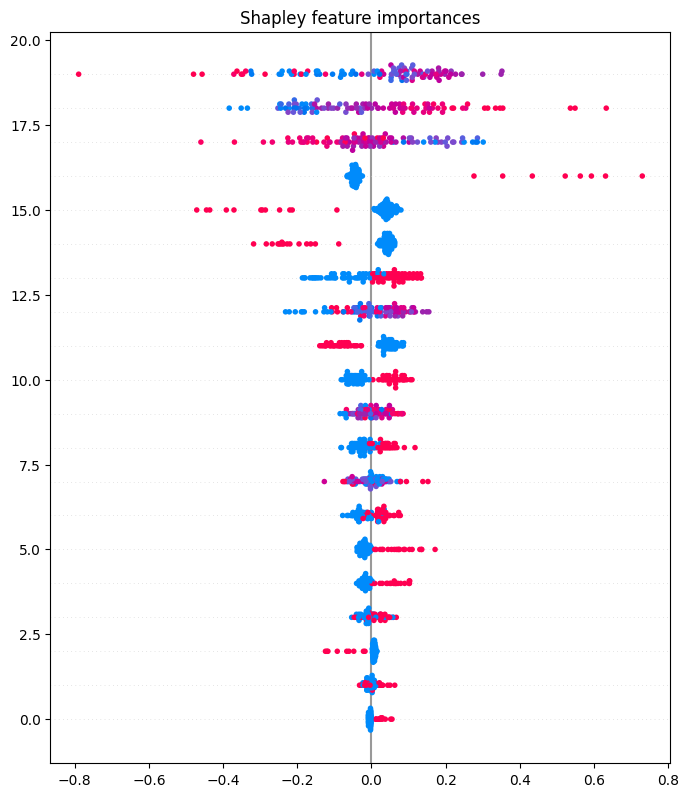

In [31]:
%matplotlib inline

# plotting shapley feature importances
# sampling from test_df as calculation can take a while
# optional: supply pre-computed shapley values by passing them as shaps=your_array

use_df = cd_hold_out.data.sample(100)
est = ct.model
figtitle = 'Shapley feature importances'

viz.plot_shap(
    estimate=est,
    df=use_df,
    figtitle=figtitle
)

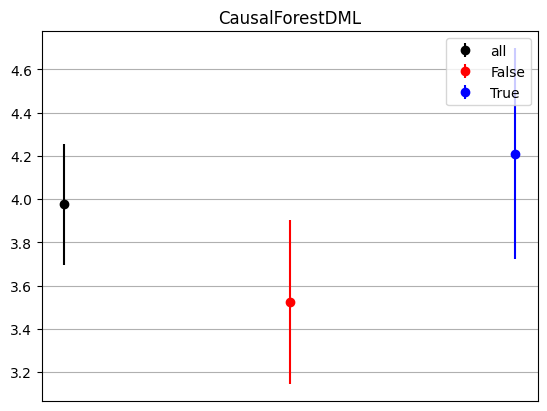

In [40]:
%matplotlib inline

# plotting out-of sample difference of outcomes between treated and untreated 
# for the points where model predicts positive vs negative impact

viz.plot_group_ate(
    scorer=ct.scorer,
    scores_dict=ct.scores,
    estimator=ct.best_estimator
)

## Custom outcome model

We also allow the user to supply a custom outcome model during training. The below example demonstrates how to use a simple linear model as outcome model. We use the same training dataset as above.

Note that you can pass any arbitrary object that has `fit()` and `predict()` methods implemented to `outcome_model`. 

In [16]:
from sklearn.linear_model import LinearRegression

ct = CausalTune(
    outcome_model=LinearRegression(),
    estimator_list=estimator_list,
    metric=metric,
    verbose=0,
    components_verbose=0,
    time_budget=time_budget,
    components_time_budget=components_time_budget,
    train_size=train_size
)


# run causaltune
ct.fit(data=cd, outcome=cd.outcomes[0])

print('---------------------')
# return best estimator
print(f"Best estimator: {ct.best_estimator}")
# config of best estimator:
print(f"Best config: {ct.best_config}")
# best score:
print(f"Best score: {ct.best_score}")

Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Initial configs: [{'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': True, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'fit_intercept': True, 'subforest_size': 4}}]
---------------------
Best estimator: backdoor.econml.metalearners.XLearner
Best config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.XLearner'}}
Best score: 0.2086960231613526
